In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.integrate import odeint
from glob import glob
import pickle
from scipy.optimize import curve_fit
from pathlib import Path
from nufeb_tools import utils,plot
import seaborn as sns
from scipy import stats
from scipy import interpolate
from sklearn.metrics import r2_score
from joblib import Parallel, delayed

In [40]:
SucroseMW = 342.3
expPath = r'../experimental-data/ecw-growth-R2.xlsx'
growthData = pd.read_excel(expPath,sheet_name='Growth')
expSucrose =pd.read_excel(expPath,sheet_name='Sucrose')
labels = ['20 g/L','10 g/L','5 g/L','2 g/L']
MeanSucrose = expSucrose.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','Sucrose']]
MeanGrowth=growthData.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','OD600']]
StDSucrose = expSucrose.groupby(['Time','Initial Sucrose']).std().reset_index()[['Time','Initial Sucrose','Sucrose']]
StDGrowth=growthData.groupby(['Time','Initial Sucrose']).std().reset_index()[['Time','Initial Sucrose','OD600']]
growth=MeanGrowth.loc[(MeanGrowth['Initial Sucrose']==10) & (MeanGrowth.Time <15)]
sucrose=MeanSucrose.loc[(MeanSucrose['Initial Sucrose']==10) & ( MeanSucrose.Time < 15)]
sucrose.Sucrose = sucrose.Sucrose/SucroseMW*1e3
growthstd=StDGrowth.loc[(StDGrowth['Initial Sucrose']==10) & (StDGrowth.Time < 15)]
sucrosestd=StDSucrose.loc[(StDSucrose['Initial Sucrose']==10) & ( StDSucrose.Time < 15)]
sucrosestd.Sucrose = sucrosestd.Sucrose/SucroseMW*1e3

c:\Users\sakkosjo\Anaconda3\envs\nufeb\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\Users\sakkosjo\Anaconda3\envs\nufeb\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [3]:
sucrosestd

,Time,Initial Sucrose,Sucrose
2,0,10,0.715037
6,4,10,0.445435
10,6,10,0.505498
14,8,10,0.588228
18,10,10,0.319509
22,13,10,0.262469


In [4]:
def collect_data(folder):
    SucroseMW = 342.3
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    CellNum2OD = Volume*1e6/0.3e-8
    Biomass2OD = .44*Volume*1e18
    temp = pd.concat([x.biomass.ecw.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD600','Hours','Sucrose']
    temp['Sucrose']=temp['Sucrose']#*SucroseMW*1e-3
    temp['S0'] = temp.Sucrose.iloc[0]*SucroseMW*1e-3
    return temp

In [5]:
BASE_DIR = Path('E:/ecw/runs')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
df = pd.concat(tmp,ignore_index=True)
df.S0.unique()

array([ 6.96  ,  3.53  ,  9.02  , 19.3   , 15.9   ,  6.27  , 11.1   ,
       10.    , 16.6   ,  4.22  , 17.9   ,  0.0993, 10.4   , 12.5   ,
       17.3   , 15.2   ,  2.16  ,  5.59  , 18.6   , 14.5   , 13.8   ,
       13.1   ,  4.91  ,  2.84  , 11.8   ,  7.65  ,  9.71  ,  8.34  ,
       20.    ,  0.787 ,  1.47  ])

In [6]:
temp = df.loc[(df.Hours < 15) & (df.S0 ==10)]



In [7]:
from matplotlib import transforms
import matplotlib as mpl
def label_panel(ax, letter, *,
                offset_left=0.5, offset_up=0.1, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

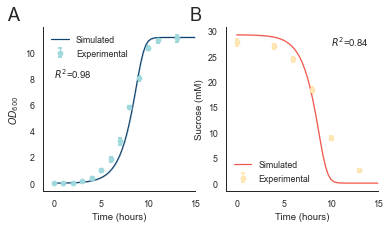

In [8]:
capsize=2
capthick=2
sns.set_context("paper")
sns.set_style("white")
g=interpolate.interp1d(temp.Hours,temp.OD600)
r2g = r2_score(growth.OD600, g(growth.Time))
suc=interpolate.interp1d(temp.Hours,temp.Sucrose)
f, axes = plt.subplots(ncols=2,sharex=True,figsize=(6,3))
axes[0].errorbar(growth.Time,growth.OD600,yerr=growthstd.OD600,ls='',marker='o',capsize=capsize,capthick=capthick,label='Experimental',c="#9fd9de")
axes[1].errorbar(sucrose.Time,sucrose.Sucrose,yerr=sucrosestd.Sucrose,ls='',marker='o',capsize=capsize,capthick=capthick,label='Experimental',c="#ffe6b2")
#sns.scatterplot(x='Time',y='OD600',data=growthData.loc[growthData['Initial Sucrose']==10],ax=axes[0],label='Experimental')
sns.scatterplot(x='Time',y='Sucrose',data=sucrose,ax=axes[1])
sns.lineplot(x='Hours',y='OD600',data=df.loc[df.S0==10],ax=axes[0],label='Simulated',color="#104470")
#axes[0].plot(df.Hours,df.OD600,color='red',label='Simulated')
sns.lineplot(x='Hours',y='Sucrose',data=df.loc[df.S0==10],ax=axes[1],label='Simulated',color="#f1574c")
r2s = r2_score(sucrose.Sucrose, suc(sucrose.Time))
#sns.lineplot(x='Hours',y='OD600',data=df,ax=axes[0],palette='Reds',label='Simulated')
axes[0].set_xlim(right=15)
axes[0].text(0.005,8, f"$R^2$={r2g:.2f}")
axes[0].legend(frameon=False,loc='upper left')
axes[1].legend(frameon=False,loc='lower left')
axes[0].set_ylabel(r'$OD_{600}$')
axes[0].set_xlabel('Time (hours)')
axes[1].set_xlabel('Time (hours)')
axes[1].set_ylabel('Sucrose (mM)')
axes[1].text(10, 27, f"$R^2$={r2s:.2f}")
label_panel(axes[0],'A')
label_panel(axes[1],'B')
sns.despine()
f.savefig(r"../figures/ec-validation.png", dpi=600,bbox_inches="tight")
plt.show()


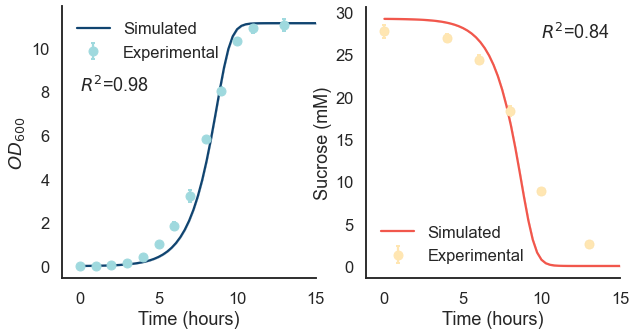

In [17]:
capsize=2
capthick=2
sns.set_context("talk")
sns.set_style("white")
g=interpolate.interp1d(temp.Hours,temp.OD600)
r2g = r2_score(growth.OD600, g(growth.Time))
suc=interpolate.interp1d(temp.Hours,temp.Sucrose)
f, axes = plt.subplots(ncols=2,sharex=True,figsize=(10,5))
axes[0].errorbar(growth.Time,growth.OD600,yerr=growthstd.OD600,ls='',marker='o',capsize=capsize,capthick=capthick,label='Experimental',c="#9fd9de")
axes[1].errorbar(sucrose.Time,sucrose.Sucrose,yerr=sucrosestd.Sucrose,ls='',marker='o',capsize=capsize,capthick=capthick,label='Experimental',c="#ffe6b2")
#sns.scatterplot(x='Time',y='OD600',data=growthData.loc[growthData['Initial Sucrose']==10],ax=axes[0],label='Experimental')
sns.scatterplot(x='Time',y='Sucrose',data=sucrose,ax=axes[1])
sns.lineplot(x='Hours',y='OD600',data=df.loc[df.S0==10],ax=axes[0],label='Simulated',color="#104470")
#axes[0].plot(df.Hours,df.OD600,color='red',label='Simulated')
sns.lineplot(x='Hours',y='Sucrose',data=df.loc[df.S0==10],ax=axes[1],label='Simulated',color="#f1574c")
r2s = r2_score(sucrose.Sucrose, suc(sucrose.Time))
#sns.lineplot(x='Hours',y='OD600',data=df,ax=axes[0],palette='Reds',label='Simulated')
axes[0].set_xlim(right=15)
axes[0].text(0.005,8, f"$R^2$={r2g:.2f}")
axes[0].legend(frameon=False,loc='upper left')
axes[1].legend(frameon=False,loc='lower left')
axes[0].set_ylabel(r'$OD_{600}$')
axes[0].set_xlabel('Time (hours)')
axes[1].set_xlabel('Time (hours)')
axes[1].set_ylabel('Sucrose (mM)')
axes[1].text(10, 27, f"$R^2$={r2s:.2f}")

sns.despine()
f.savefig(r"../figures/ec-validation-talk.png", dpi=600,bbox_inches="tight")
plt.show()

In [50]:
BASE_DIR = Path('E:/ecw-check/runs')
folders = [path for path in BASE_DIR.resolve().iterdir() if path.is_dir()]
tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
data = pd.concat(tmp,ignore_index=True)
df = data.groupby(['Hours','S0']).mean().reset_index()
df2 = expSucrose.copy()
df2.Sucrose = expSucrose.Sucrose/SucroseMW*1e3
df2=df2.groupby(['Time','Initial Sucrose']).mean().reset_index()


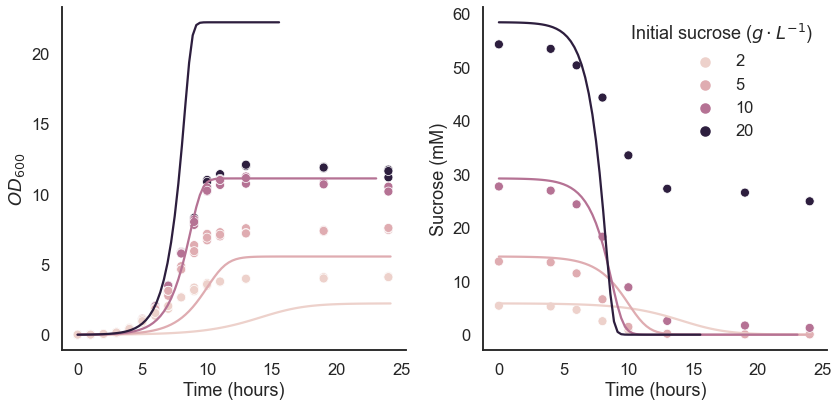

In [51]:
sns.set_context("talk")
sns.set_style("white")
f, axes = plt.subplots(ncols=2,figsize=(12,6),sharex=True)
sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=growthData,ax=axes[0],legend=False)
sns.scatterplot(x='Time',y='Sucrose',hue='Initial Sucrose',data=df2,ax=axes[1])
sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0],legend=False)
sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1],legend=False)
axes[1].legend(frameon=False,title=r'Initial sucrose ($g \cdot L^{-1}$)')
for ax in axes.ravel():
    ax.set_xlabel('Time (hours)')
axes[0].set_ylabel(r'$OD_{600}$')
axes[1].set_ylabel(r'Sucrose (mM)')
#axes[0].legend.remove()
sns.despine()
f.tight_layout()
f.savefig(r'../figures/ec-sucrose-talk.png',bbox_inches='tight',dpi=600)

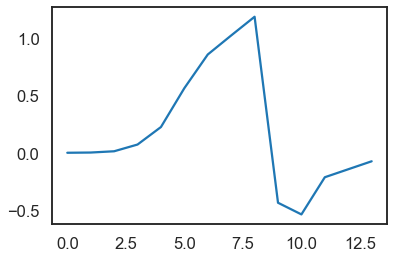

In [10]:
plt.plot(growth.Time,growth.OD600 - g(growth.Time))

In [11]:
SucroseMW = 342.3
O2MW = 32
CO2MW = 44.01
dens = 1e9
Volume = 1e-4*1e-4*1e-5 #m^3
mlm3 = 1e6 #mL/m^3
cellsperOD=8e8 #cells/mL @OD 1
#CellNum2OD = Volume*cellsperOD*mlm3
CellNum2OD = Volume/1e-9
Biomass2OD = 1e12
tStep2Days = 10/3600/24
sucs = np.linspace(0,1,6)
pctC = 0.5
light = 1.00e-01 #kg/m^3
co2 = 4e-1
mu_max = 0.047*24 #2.25e-05# 1/d
K_m_light = 3.5e-04
K_m_co2 = 5e-2
def cells2OD(x):
    return (x+4e7)/1e9/(Volume*mlm3)
    
def func(x,K,r,N0):
    return K/(1  + ((K-N0)/N0)*np.exp(-r*x))
def logistic_regression(x,y):
    popt, pcov = curve_fit(func, 
                        x, 
                        y,          
                        p0 = [0.80309017, 0.24164053, 0.01670965],        
                        maxfev=10000
                        )
    return popt




In [12]:
1/(Volume*mlm3)*8e-8

0.7999999999999998

In [13]:
temp = experimentalData.groupby(['Initial Sucrose','Replicate']).apply(lambda x: logistic_regression(x['Time'],x['OD600']))

NameError: name 'experimentalData' is not defined

In [ ]:
experimentalFits = pd.DataFrame(columns=['Initial Sucrose','Replicate','Max','mu','t0'])
for s in temp.reset_index().iterrows():
    experimentalFits=experimentalFits.append(pd.DataFrame([[s[1]['Initial Sucrose'],s[1]['Replicate'],s[1][0][0],s[1][0][1],s[1][0][2]]],columns=['Initial Sucrose','Replicate','Max','mu','t0']),ignore_index=True)

In [ ]:
experimentalFits.groupby(['Initial Sucrose']).mean()

,Max,mu,t0
Initial Sucrose,,,
2,4.057535,0.669260,0.039871
5,7.479576,0.874520,0.014437
10,10.951256,0.983898,0.005683
20,11.939218,0.905239,0.008513


In [ ]:
for path in types:
    df = pd.read_csv(path,usecols=[0,1],names=['Time','Cells'],skiprows=1,delimiter='	')
    df.Time = df.Time/60/60*10 #convert timesteps (10s) to days
    df['OD'] = df.iloc[:,1]*CellNum2OD
df

,Time,Cells,OD
0,0.000000,100,0.0100
1,0.277778,100,0.0100
2,0.555556,105,0.0105
3,0.833333,113,0.0113
4,1.111111,122,0.0122
...,...,...,...
346,96.111111,2161,0.2161
347,96.388889,2161,0.2161
348,96.666667,2161,0.2161
349,96.944444,2161,0.2161


In [ ]:
cells2OD(100)

400000.9999999999

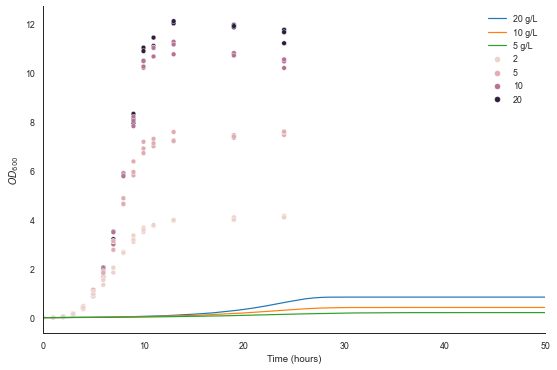

In [ ]:
sns.set_context('paper')
sns.set_style('white')
mus =list()
f, ax = plt.subplots(figsize=(9,6))
for path,label in zip(types,labels):
    df = pd.read_csv(path,usecols=[0,1],names=['Time','Cells'],skiprows=1,delimiter='	')
    df.index = df.Time/60/60*10 #convert timesteps (10s) to days
    df.index.name='Hours'
    df['OD'] = df.iloc[:,1]*CellNum2OD
    ax.plot(df.OD,label=label)
    popt, pcov = curve_fit(func,df.index.values,df.OD,p0=[0.80309017, 0.24164053, 0.01670965])
    mus.append(popt[1])
    #ax.plot(df.index.values,func(df.index.values,*popt),ls='--')

ax.legend().remove()
ax.set_xlim([0,50])
#ax.plot(Control.Time,Control.OD600,label='Experimental',c='k')
#popt, pcov = curve_fit(func,Control.Time,Control.OD600,p0=[0.80309017, 0.24164053, 0.01670965])
#ax.plot(Control.Time,func(Control.Time,*popt),ls='--',c='grey')
sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=Control,ax=ax)
ax.set_xlabel('Time (hours)')
ax.set_ylabel(r'$OD_{600}$')
ax.legend(frameon=False)

sns.despine()

In [ ]:
growth = pd.DataFrame([mus,[20,10,5]]).T
growth.columns=['mu','Sucrose']
growth

,mu,Sucrose
0,0.320248,20.0
1,0.255373,10.0
2,0.183655,5.0


In [ ]:
df

,Time,Cells,OD
Hours,,,
0.000000,0,100,1000000.0
0.277778,100,100,1000000.0
0.555556,200,105,1050000.0
0.833333,300,113,1130000.0
1.111111,400,122,1220000.0
...,...,...,...
96.111111,34600,2161,21610000.0
96.388889,34700,2161,21610000.0
96.666667,34800,2161,21610000.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


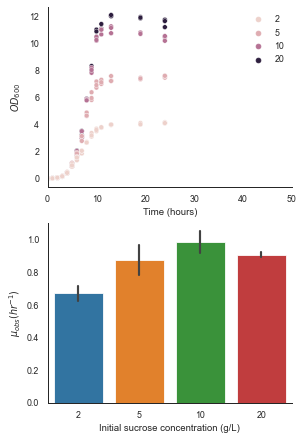

In [ ]:
#f,axes = plt.subplots(nrows=4,ncols=2,figsize=(12,15))
colors = ['#e34a33','#fdbb84','#fee8c8']
fig = plt.figure(constrained_layout=True, figsize=(7.5,6))
gs0 = gridspec.GridSpec(4, 2, figure=fig)
sns.set_context('paper')
sns.set_style('white')

ax2 = fig.add_subplot(gs0[2:, 0])
ax1 = fig.add_subplot(gs0[:2, 0])
""" mus =list()
for i,(path,label) in enumerate(zip(types,labels)):
    df = pd.read_csv(path,usecols=[0,1],names=['Time','Cells'],skiprows=1,delimiter='	')
    df['Hours'] = df.Time/60/60*10 #convert timesteps (10s) to days
    df['OD600'] = df['Cells']*CellNum2OD
    #ax1.plot(df.OD,label=label,c=colors[i])
    sns.lineplot(x='Hours',y='OD600',data=df)
    popt, pcov = curve_fit(func,df.index.values,df.OD600,p0=[0.80309017, 0.24164053, 0.01670965])
    mus.append(popt[1]) """


ax1.legend().remove()
ax1.set_xlim([0,50])

sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=experimentalData,ax=ax1)

ax1.set_xlabel('Time (hours)')
ax1.set_ylabel(r'$OD_{600}$')
ax1.legend(frameon=False)


sns.barplot(x='Initial Sucrose',y='mu',data=experimentalFits,ax=ax2,ci='sd')
ax2.set_xlabel('Initial sucrose concentration (g/L)')
ax2.set_ylabel(r'$\mu_{obs} (hr^{-1})$ ')

sns.despine()


fig.align_ylabels()
#fig.savefig('validationEC.png',dpi=600)
#f.tight_layout()



In [ ]:
data = utils.get_data(r'D:\runs\Run_0_100_12_1_2021-07-16')

In [ ]:
data.avg_con

,O2,Sucrose,CO2
Hours,,,
0.000000,0.281250,5.842828e+01,0.679391
0.277778,0.281249,5.839068e+01,0.679392
0.555556,0.281249,5.835118e+01,0.679392
0.833333,0.281249,5.830973e+01,0.679392
1.111111,0.281249,5.826620e+01,0.679392
...,...,...,...
96.111111,0.281249,1.955348e-36,0.679392
96.388889,0.281249,1.455464e-36,0.679392
96.666667,0.281249,1.083694e-36,0.679392


In [ ]:
Volume = 1e-4*1e-4*1e-5 #m^3
CellNum2OD = Volume/1e-9
df2 = pd.concat([data.ntypes.ecw*CellNum2OD,data.ntypes.step/60/60*data.timestep],axis=1)
df2.columns=['OD600','Hours']
SucroseMW = 342.3

In [ ]:
df.groupby('S0').mean()['mu']

S0
0     0.001433
1     0.002010
2     0.163883
3     0.207408
4     0.216891
5     0.213029
10    0.264609
12    0.255564
14    0.301827
16    0.294783
18    0.277585
20    0.299615
Name: mu, dtype: float64

In [ ]:
growthRates = {1 : 0.002,2:.163,5:.21,10:.265,20:.2996}

In [ ]:
data.avg_con.Sucrose[0]*SucroseMW/1e3

20.0

[0.85153994 0.32024766 0.00115569]


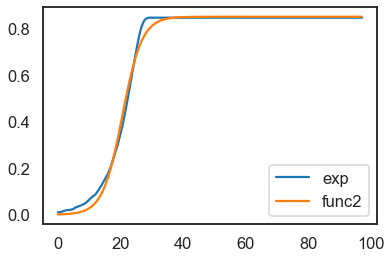

In [ ]:
def grow(x,a,k,b):
    return a/(1+b*np.exp(x*k))

popt2, pcov2 = curve_fit(func,df2.Hours, df2.OD600)
print(popt2)
xrange= np.arange(0,df2.Hours.max(),1)

plt.plot(df2.Hours,df2.OD600,label='exp')
plt.plot(xrange,func(xrange,*popt2),label='func2')
plt.legend()